In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**b)Modify the code to run on co-lab without any new features**


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


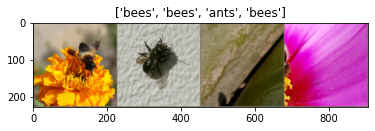

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase=='train':
              train_loss.append(epoch_loss)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#**c)plot validation loss and accuracy after every training epoch.**

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft,loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5161 Acc: 0.7500
val Loss: 0.3314 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5115 Acc: 0.7705
val Loss: 0.2941 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4406 Acc: 0.8361
val Loss: 0.2621 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.6484 Acc: 0.7336
val Loss: 0.2185 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.7425 Acc: 0.7910
val Loss: 0.5194 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4891 Acc: 0.8320
val Loss: 0.8897 Acc: 0.7516

Epoch 6/24
----------
train Loss: 0.4373 Acc: 0.8156
val Loss: 0.6117 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.3778 Acc: 0.8607
val Loss: 0.3739 Acc: 0.8497

Epoch 8/24
----------
train Loss: 0.3530 Acc: 0.8730
val Loss: 0.3374 Acc: 0.8693

Epoch 9/24
----------
train Loss: 0.2951 Acc: 0.8484
val Loss: 0.3168 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3475 Acc: 0.8689
val Loss: 0.2966 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.3201 Acc: 0.8566
val Loss: 0.2925 Acc: 0.9085

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


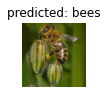

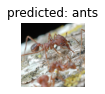

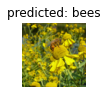

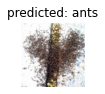

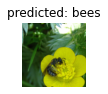

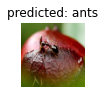

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv,loss = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6551 Acc: 0.6721
val Loss: 0.2365 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4415 Acc: 0.8197
val Loss: 0.1855 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4906 Acc: 0.7828
val Loss: 0.1905 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3586 Acc: 0.8443
val Loss: 0.2432 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.6869 Acc: 0.7172
val Loss: 0.1787 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.3336 Acc: 0.8607
val Loss: 0.1686 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5513 Acc: 0.7664
val Loss: 0.1780 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.4478 Acc: 0.8074
val Loss: 0.1601 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.3540 Acc: 0.8238
val Loss: 0.1686 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2790 Acc: 0.8770
val Loss: 0.1792 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3855 Acc: 0.8361
val Loss: 0.1711 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4171 Acc: 0.8361
val Loss: 0.1741 Acc: 0.9477

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


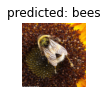

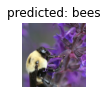

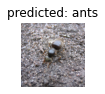

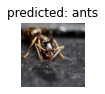

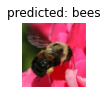

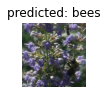

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#**d)Change the learning rate, momentum, and number of epochs at least three times to see the net effect on final validation loss and accuracy and its speed of convergence.**

0.3 0.001 15
Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 12.1658 Acc: 0.8443
val Loss: 12.0651 Acc: 0.9150

Epoch 1/14
----------
train Loss: 12.6114 Acc: 0.8361
val Loss: 11.7752 Acc: 0.9020

Epoch 2/14
----------
train Loss: 13.5251 Acc: 0.8443
val Loss: 12.1287 Acc: 0.9150

Epoch 3/14
----------
train Loss: 15.3545 Acc: 0.8279
val Loss: 8.1126 Acc: 0.9477

Epoch 4/14
----------
train Loss: 13.7631 Acc: 0.8443
val Loss: 10.3164 Acc: 0.9346

Epoch 5/14
----------
train Loss: 10.2699 Acc: 0.8689
val Loss: 11.0800 Acc: 0.9150

Epoch 6/14
----------
train Loss: 14.8637 Acc: 0.8238
val Loss: 8.8568 Acc: 0.9412

Epoch 7/14
----------
train Loss: 13.4647 Acc: 0.8443
val Loss: 8.9435 Acc: 0.9477

Epoch 8/14
----------
train Loss: 13.1512 Acc: 0.8320
val Loss: 10.6057 Acc: 0.9020

Epoch 9/14
----------
train Loss: 14.4754 Acc: 0.8074
val Loss: 8.9808 Acc: 0.9412

Epoch 10/14
----------
train Loss: 12.9663 Acc: 0.8361
val Loss: 8.8472 Acc: 0.9477

Epoch 11/14
----------
train Loss: 14.8476 Acc: 0.8566
val Loss: 11.1639 Acc: 0.8954

Epoch

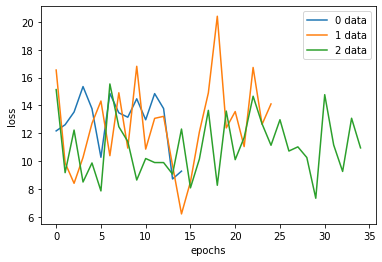

In [ ]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.

i=0;
p=0.3
eta=0.001
for epochs in [15,25,35]:
      print(p,eta,epochs)
      optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=eta, momentum=p)

      # Decay LR by a factor of 0.1 every 7 epochs
      exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

      model_itr,loss = train_model(model_conv, criterion, optimizer_conv,
                              exp_lr_scheduler, num_epochs=epochs)
      plt.plot(loss,label='%s data' % i )
      plt.ylabel('loss') 
      plt.xlabel('epochs') 
      i=i+1
      
plt.legend()
plt.show()


0.3 0.001 25
Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 14.0563 Acc: 0.8607
val Loss: 9.1661 Acc: 0.9412

Epoch 1/24
----------
train Loss: 15.4842 Acc: 0.8402
val Loss: 9.8248 Acc: 0.9477

Epoch 2/24
----------
train Loss: 11.9835 Acc: 0.8648
val Loss: 9.3490 Acc: 0.9477

Epoch 3/24
----------
train Loss: 15.6414 Acc: 0.8279
val Loss: 9.4918 Acc: 0.9412

Epoch 4/24
----------
train Loss: 12.2797 Acc: 0.8525
val Loss: 9.8061 Acc: 0.9477

Epoch 5/24
----------
train Loss: 13.5054 Acc: 0.8648
val Loss: 8.7822 Acc: 0.9477

Epoch 6/24
----------
train Loss: 9.1532 Acc: 0.8893
val Loss: 9.4284 Acc: 0.9477

Epoch 7/24
----------
train Loss: 17.4536 Acc: 0.8238
val Loss: 8.8819 Acc: 0.9477

Epoch 8/24
----------
train Loss: 19.7318 Acc: 0.8279
val Loss: 9.2668 Acc: 0.9412

Epoch 9/24
----------
train Loss: 10.8370 Acc: 0.8852
val Loss: 9.2691 Acc: 0.9477

Epoch 10/24
----------
train Loss: 14.8692 Acc: 0.8607
val Loss: 9.3333 Acc: 0.9477

Epoch 11/24
----------
train Loss: 16.6630 Acc: 0.8115
val Loss: 9.7946 Acc: 0.9346

Epoch 12/24
-

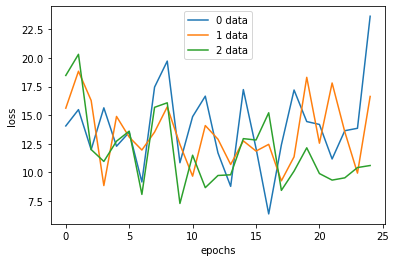

In [ ]:
i=0;
p=0.3
epochs=25
for eta in [0.001,0.01,0.1]:
      print(p,eta,epochs)
      optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=eta, momentum=p)

      # Decay LR by a factor of 0.1 every 7 epochs
      exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

      model_itr,loss = train_model(model_conv, criterion, optimizer_conv,
                              exp_lr_scheduler, num_epochs=epochs)
      plt.plot(loss,label='%s data' % i )
      plt.ylabel('loss') 
      plt.xlabel('epochs') 
      i=i+1
      
plt.legend()
plt.show()

0.1 0.001 25
Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 14.0842 Acc: 0.8156
val Loss: 7.6571 Acc: 0.9477

Epoch 1/24
----------
train Loss: 15.2146 Acc: 0.8648
val Loss: 9.0004 Acc: 0.9412

Epoch 2/24
----------
train Loss: 13.4743 Acc: 0.8689
val Loss: 7.6713 Acc: 0.9412

Epoch 3/24
----------
train Loss: 17.5479 Acc: 0.7951
val Loss: 8.2977 Acc: 0.9477

Epoch 4/24
----------
train Loss: 14.1043 Acc: 0.8443
val Loss: 8.3781 Acc: 0.9477

Epoch 5/24
----------
train Loss: 9.3610 Acc: 0.8648
val Loss: 8.6930 Acc: 0.9477

Epoch 6/24
----------
train Loss: 15.0291 Acc: 0.8279
val Loss: 9.4448 Acc: 0.9477

Epoch 7/24
----------
train Loss: 12.8015 Acc: 0.8566
val Loss: 8.4253 Acc: 0.9542

Epoch 8/24
----------
train Loss: 14.4520 Acc: 0.8361
val Loss: 8.3747 Acc: 0.9412

Epoch 9/24
----------
train Loss: 11.2783 Acc: 0.9016
val Loss: 9.1385 Acc: 0.9216

Epoch 10/24
----------
train Loss: 14.7497 Acc: 0.8443
val Loss: 9.3770 Acc: 0.9477

Epoch 11/24
----------
train Loss: 13.6682 Acc: 0.8402
val Loss: 8.9572 Acc: 0.9477

Epoch 12/24
-

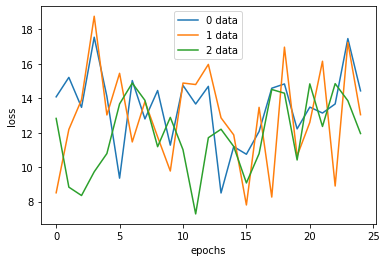

In [ ]:
i=0;
eta=0.001
epochs=25
for p in [0.1,0.3,0.9]:
      print(p,eta,epochs)
      optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=eta, momentum=p)

      # Decay LR by a factor of 0.1 every 7 epochs
      exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

      model_itr,loss = train_model(model_conv, criterion, optimizer_conv,
                              exp_lr_scheduler, num_epochs=epochs)
      plt.plot(loss,label='%s data' % i )
      plt.ylabel('loss') 
      plt.xlabel('epochs') 
      i=i+1
      
plt.legend()
plt.show()

#**e)Introduce weight decay (L2 penalty on weights) and find a good value for the weight decay factor.**

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.

for wt_decay in [0.0001,0.001,0.01,0.1]:
  print("weight decay=",wt_decay)
  optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9,weight_decay=wt_decay)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

  model_conv,loss = train_model(model_conv, criterion, optimizer_conv,
                          exp_lr_scheduler, num_epochs=25)

weight decay= 0.0001
Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7358 Acc: 0.6475
val Loss: 0.2862 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4419 Acc: 0.8115
val Loss: 0.1898 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.7191 Acc: 0.6721
val Loss: 0.3274 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.6223 Acc: 0.7541
val Loss: 0.1394 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.5129 Acc: 0.7951
val Loss: 0.1650 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.6472 Acc: 0.7623
val Loss: 0.2605 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4782 Acc: 0.7992
val Loss: 0.2478 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4292 Acc: 0.8156
val Loss: 0.1718 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3193 Acc: 0.8689
val Loss: 0.1608 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3825 Acc: 0.8361
val Loss: 0.1604 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3468 Acc: 0.8484
val Loss: 0.1617 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3241 Acc: 0.8934
val Loss: 0.1711 Acc: 0.9477

Epoch 12/24
----------
t

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





#**Comments & Insights**
1)Weight decay of 0.001 is the best which has the best accuracy of 0.96.

2)p=0.1 has the lowest loss. p=0.9 has less oscillations and converges faster.best accuracy=0.96 for p=0.6 which is the best and greater than that of p=0.3,0.9.

3)lr=0.001 has the lowest loss but has slow convergence and loss oscillates whereas lr=0.01 has much faster convergence and oscillates less and has quite low loss as well.best accuracy=0.95 which is the best and greater than that of lr=0.001,0.1.

4)epoch=25 has the lowest loss but oscillates a lot whereas epoch=35 has fast covergence with less oscillations and quite low loss.All the three have the same best accuracy.